# Overfitting and Regularization

## Imports

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn import compose

In [140]:
set_config(display='diagram')

## Settings

In [188]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

In [142]:
DEGREES

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [143]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

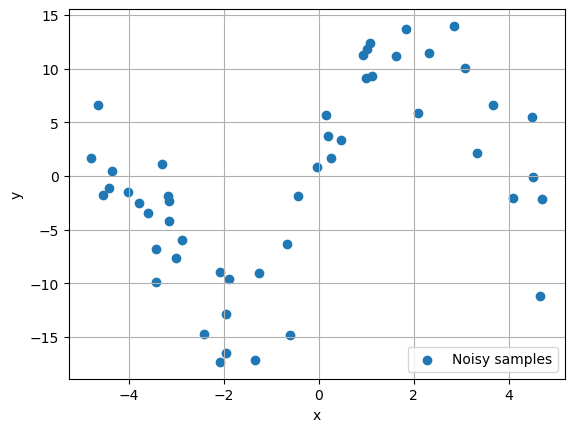

In [144]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

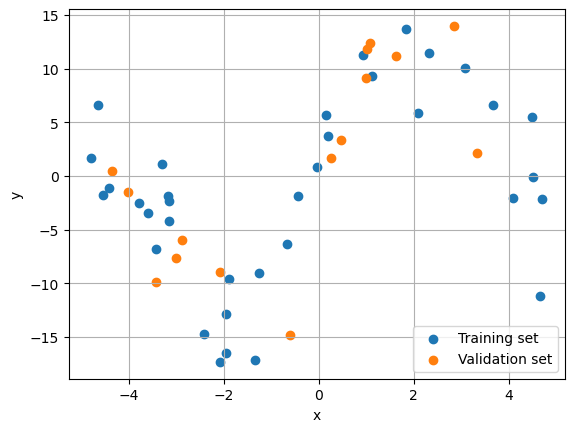

In [145]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [146]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [147]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

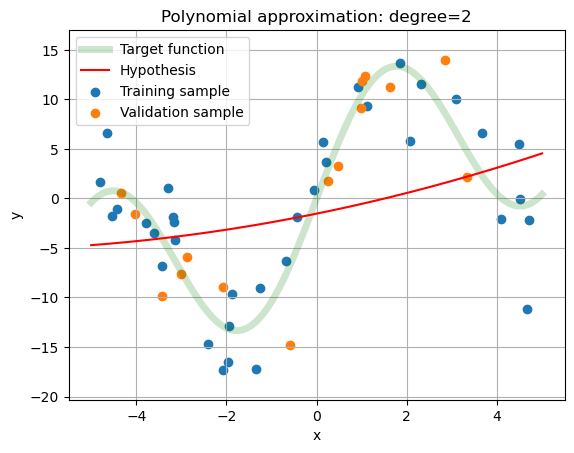

In [148]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

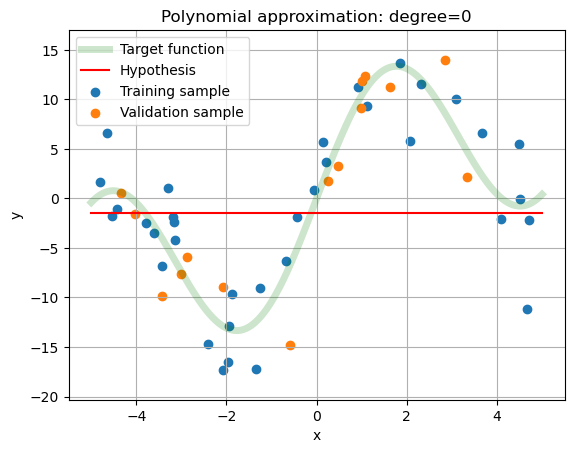

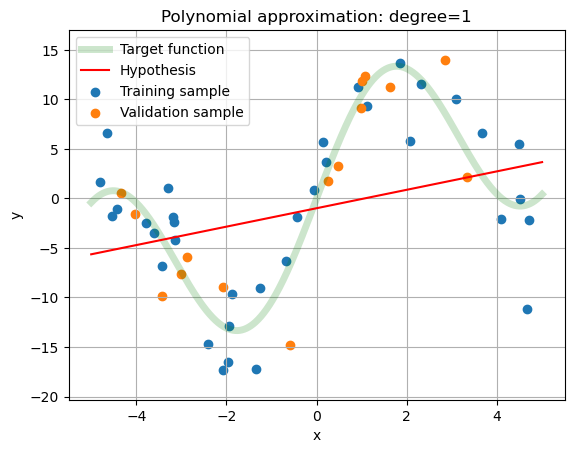

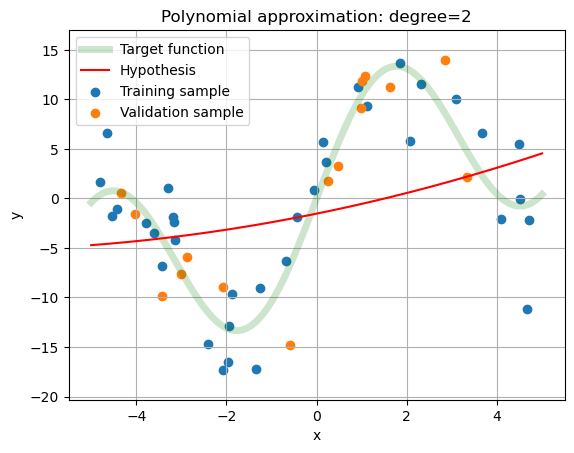

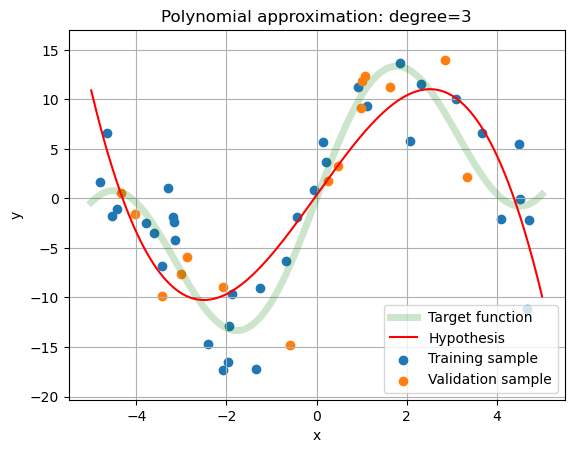

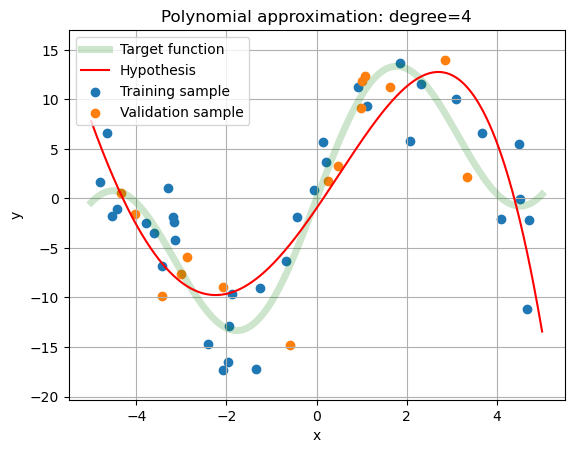

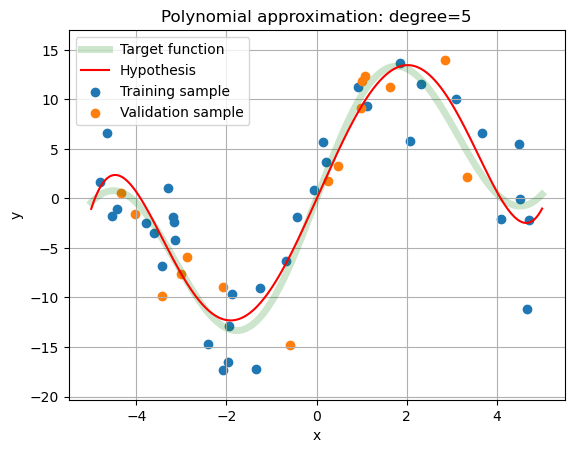

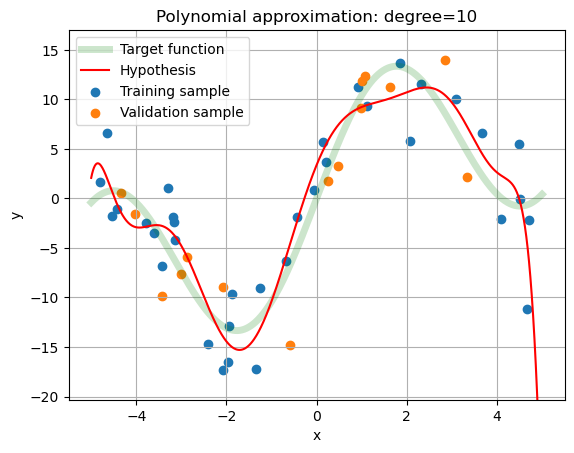

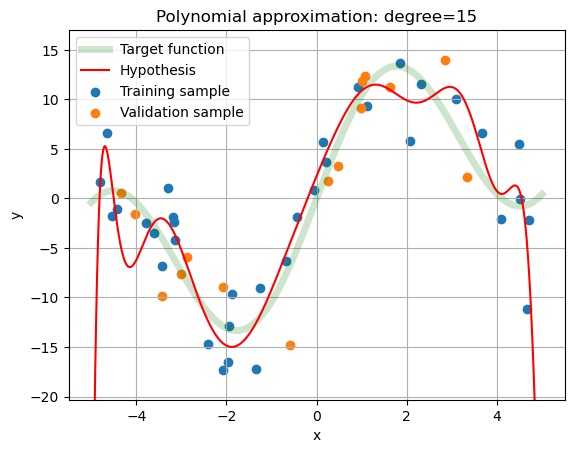

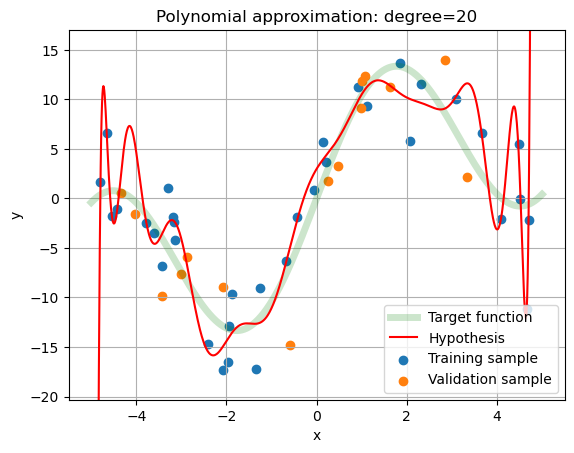

In [149]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

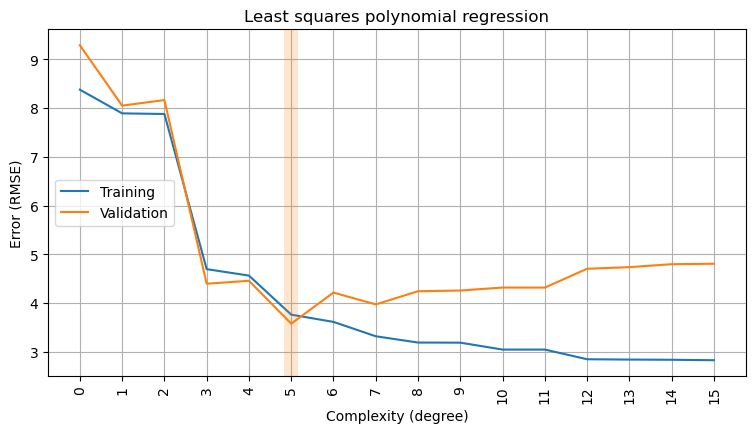

In [150]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [151]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

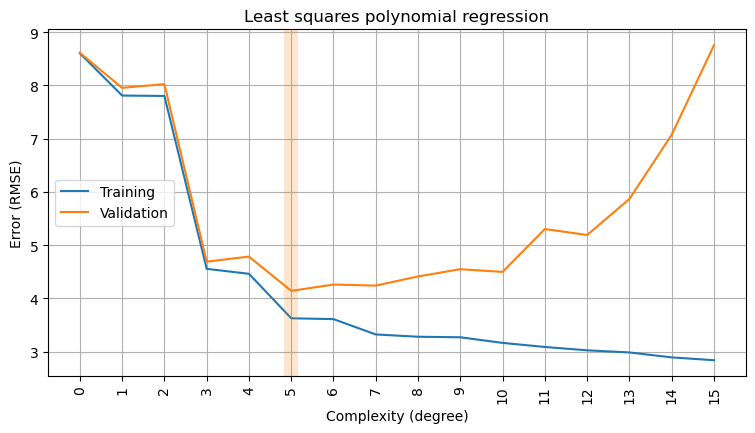

In [152]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [153]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

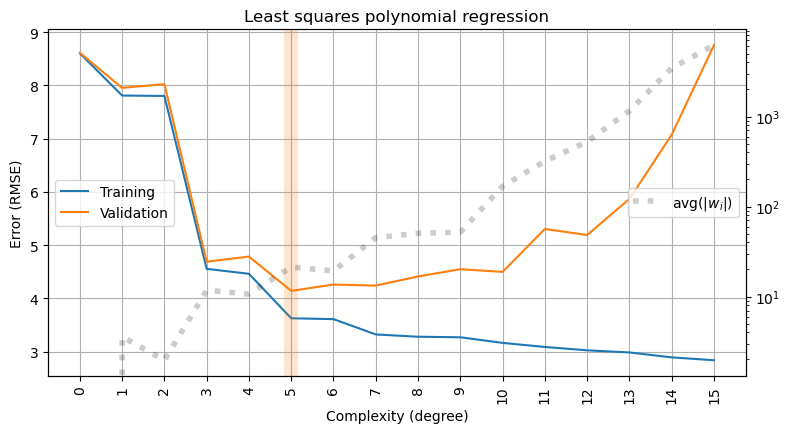

In [154]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

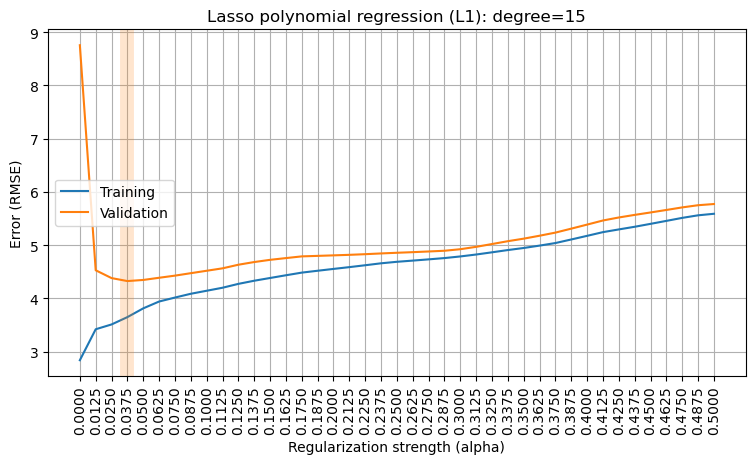

In [155]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

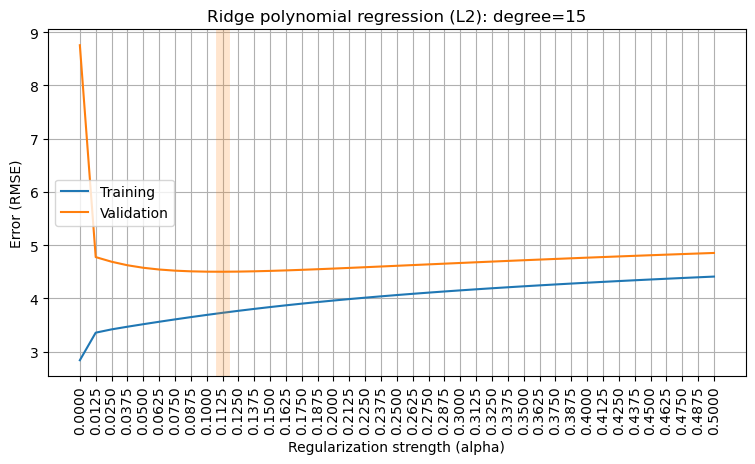

In [156]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [157]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [158]:
x_dtrain, x_dvalid, y_dtrain, y_dvalid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [159]:
diab_degrees = np.linspace(1, 10, 0 + 10, dtype=int)

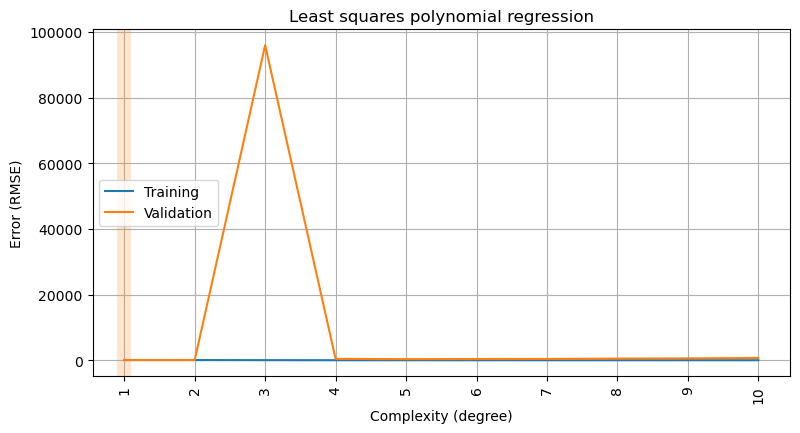

In [160]:
rmse_train, rmse_valid = [], []
for degree in diab_degrees:
    reg = make_model(degree).fit(x_dtrain, y_dtrain)
    rmse_train.append(rmse(reg.predict(x_dtrain), y_dtrain))
    rmse_valid.append(rmse(reg.predict(x_dvalid), y_dvalid))
    
plot_fitting_graph(diab_degrees, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [161]:
diab_degrees = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

lets drop the 3rd degree to improve scaling 

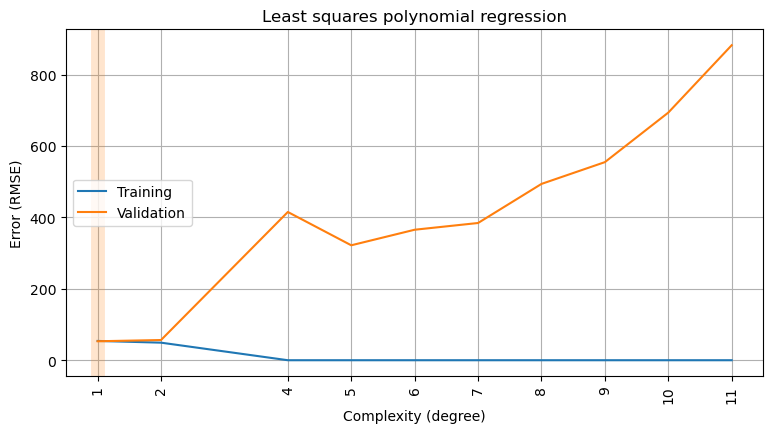

In [162]:
rmse_train, rmse_valid = [], []
for degree in diab_degrees:
    reg = make_model(degree).fit(x_dtrain, y_dtrain)
    rmse_train.append(rmse(reg.predict(x_dtrain), y_dtrain))
    rmse_valid.append(rmse(reg.predict(x_dvalid), y_dvalid))
    
plot_fitting_graph(diab_degrees, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [163]:
diab_degrees[np.argmin(rmse_valid)]

1

1st degree is the optimal value, starting from the 2nd degree fit for the validation set starts to worsen aka Overfitting

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [164]:
diab_degrees = np.linspace(1, 15, 0 + 15, dtype=int)

полиномизируем три столбца - age, sex, bmi - остальные оставляем в том же виде

In [262]:
ct = compose.ColumnTransformer(
transformers=[('polf', PolynomialFeatures(degree=15, include_bias=False), ['age', 'sex', 'bmi'])], remainder = 'passthrough'
)

In [263]:
x_t_dtrain = ct.fit_transform(x_dtrain)

In [264]:
x_t_dtrain.shape

(309, 822)

#### L1

In [265]:
# from ipywidgets import IntProgress
# from IPython.display import display
# import time

оригинальные веса

In [266]:
ar = LinearRegression().fit(x_t_dtrain, y_dtrain).coef_
ar

array([[ 6.73034308e+11,  3.32527815e+13,  1.41661167e+11,
        -5.16066248e+09,  1.84141606e+12,  8.41623393e+10,
        -5.55330751e+15,  3.41111382e+11,  1.13356359e+10,
        -5.74649097e+08, -1.02350486e+10,  1.63543395e+10,
        -2.97360823e+14,  2.27943676e+11, -6.70766281e+09,
         1.22129952e+14, -6.27134909e+13,  3.11861492e+10,
         8.32064992e+08,  4.54186936e+08, -1.66351575e+09,
        -3.00899496e+08,  2.29064705e+12,  4.39857356e+10,
        -2.02603645e+07, -1.99258258e+13, -3.71906943e+13,
        -1.79790884e+10, -8.68519819e+07,  1.25927935e+11,
         1.63451657e+13, -5.00782269e+12,  2.17817043e+09,
        -8.09605790e+07,  9.41766032e+08, -3.93177832e+09,
         3.70113087e+08,  2.53227733e+11,  2.06805703e+09,
         4.58927121e+09, -1.56159733e+12, -7.22827557e+12,
        -3.18638908e+09, -1.95730222e+09, -7.72944067e+09,
        -1.46408452e+12,  2.96324544e+12, -6.60896485e+07,
         4.85355313e+08, -3.01724494e+11,  2.41264492e+1

In [267]:
ar.mean()

53189404213756.61

UserWarning: With alpha=0, this algorithm does not converge well - начинаю ALPHAS не с нуля

In [268]:
ALPHAS = np.linspace(0.001, 0.5, 1 + 40)

Распределение средних весов при L1

for alpha =  0.001 weights are:
 10.374130060873053
for alpha =  0.013475 weights are:
 2.883323144306386
for alpha =  0.02595 weights are:
 1.1410657955384973
for alpha =  0.038425 weights are:
 1.0917551999644126
for alpha =  0.0509 weights are:
 1.0424931830171165
for alpha =  0.063375 weights are:
 0.9931460197160298
for alpha =  0.07585 weights are:
 0.9478664922571135
for alpha =  0.088325 weights are:
 0.9550678784118881
for alpha =  0.1008 weights are:
 0.9622778346927748
for alpha =  0.113275 weights are:
 0.969516798047946
for alpha =  0.12575 weights are:
 0.9767431328932412
for alpha =  0.138225 weights are:
 0.9839433900533898
for alpha =  0.1507 weights are:
 0.9911494193642776
for alpha =  0.16317500000000001 weights are:
 0.9985406976491531
for alpha =  0.17565 weights are:
 1.0083625592950392
for alpha =  0.188125 weights are:
 1.018217473399777
for alpha =  0.2006 weights are:
 1.0293192629592822
for alpha =  0.21307500000000001 weights are:
 1.040420843765159
for alp

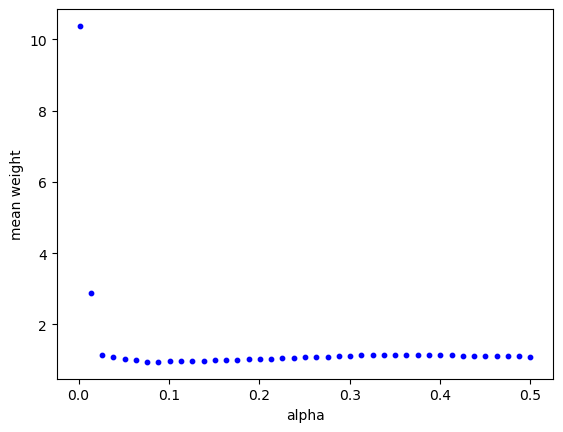

In [270]:
for a in ALPHAS:    
    l = Lasso(alpha=a, random_state=SEED, max_iter=50000).fit(x_t_dtrain, y_dtrain).coef_.mean()
    print('for alpha = ', a, 'weights are:\n', l)
    m = plt.scatter(x=a, y=l, s=10, color = 'b')
    plt.xlabel('alpha')
    plt.ylabel('mean weight')  

#### L2

for alpha =  0.001 weights are:
 8.753713981735151
for alpha =  0.013475 weights are:
 2.767669306099552
for alpha =  0.02595 weights are:
 2.013625351933344
for alpha =  0.038425 weights are:
 1.7140220864826121
for alpha =  0.0509 weights are:
 1.5527531280508162
for alpha =  0.063375 weights are:
 1.4517942650905777
for alpha =  0.07585 weights are:
 1.3825071068769865
for alpha =  0.088325 weights are:
 1.3318912823104372
for alpha =  0.1008 weights are:
 1.293190179958274
for alpha =  0.113275 weights are:
 1.2625443393938307
for alpha =  0.12575 weights are:
 1.2375895350292239
for alpha =  0.138225 weights are:
 1.216797263440474
for alpha =  0.1507 weights are:
 1.199136047103911
for alpha =  0.16317500000000001 weights are:
 1.183885096498634
for alpha =  0.17565 weights are:
 1.1705259316320575
for alpha =  0.188125 weights are:
 1.1586763853035398
for alpha =  0.2006 weights are:
 1.1480488342038904
for alpha =  0.21307500000000001 weights are:
 1.1384228800673681
for alpha 

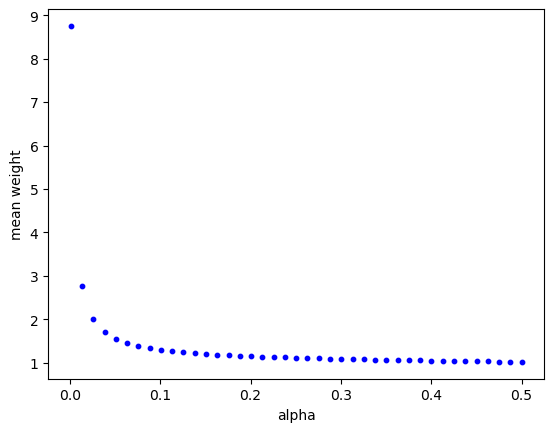

In [271]:
a = 0
for a in ALPHAS:    
    r = Ridge(alpha=a, random_state=SEED, max_iter=50000).fit(x_t_dtrain, y_dtrain).coef_.mean()
    print('for alpha = ', a, 'weights are:\n', r)
    m = plt.scatter(x=a, y=r, s=10, color = 'b')
    plt.xlabel('alpha')
    plt.ylabel('mean weight')    

#### Summary

Среднее значение весов значительно меньше при применении Ridge и Lasso

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

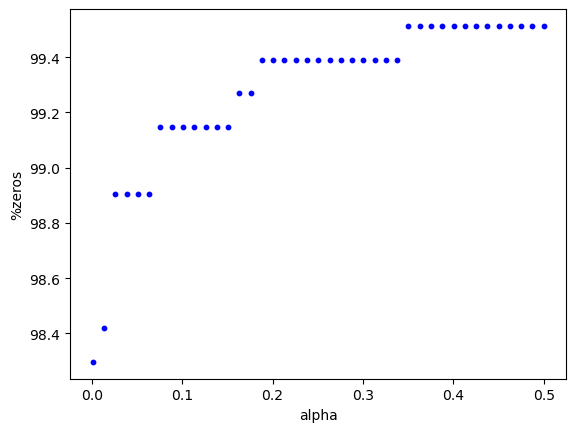

In [273]:
for a in ALPHAS:    
    l = Lasso(alpha=a, random_state=SEED, max_iter=50000).fit(x_t_dtrain, y_dtrain).coef_
    m = plt.scatter(x=a, y=abs(len(l) - np.count_nonzero(l))*100/len(l), s=10, color = 'b')
    plt.xlabel('alpha')
    plt.ylabel('%zeros')

#### L2

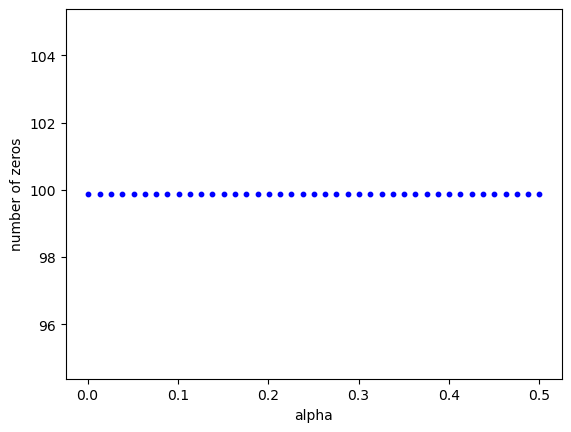

In [274]:
for a in ALPHAS:    
    r = Ridge(alpha=a, random_state=SEED, max_iter=50000).fit(x_t_dtrain, y_dtrain).coef_
    m = plt.scatter(x=a, y=abs(len(r) - np.count_nonzero(r))*100/len(l), s=10, color = 'b')
    plt.xlabel('alpha')
    plt.ylabel('number of zeros')

#### Summary

что-то не так)

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [ ]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

#### L1

In [ ]:
## your code

#### L2

In [ ]:
## your code

#### Summary



In [ ]:
## your observations/conclusions